# Intro

When we published the [GHOST paper](https://doi.org/10.1021/acs.jcim.1c00160) on shifting the decision boundary to improve the predictive performance of classification models built on imbalanced datasets, we only considered binary classifiers (e.g. active/inactive, soluble/insoluble, etc.). I was recently asked if the method could be extended to ternary (three-class) classifiers. This post is about doing that; the code will eventually find its way into the [open-source ghostml package](https://github.com/rinikerlab/GHOST) once we've had a chance to review and test it more thoroughly.


In order for this to make sense, I think I should start with some explanation of the way I've approached the problem:

## Using thresholds in ternary problems

Things are a bit more complicated here than with binary classifiers. For the binary case we just have a single threshold which determines whether an instance is predicted to be in class 0 or 1. So, assuming that we optimized based on the probability of class 1, we can formulate the decision as:
```
if probabilities[1] >= threshold:
   prediction = 1
else:
   prediction = 0
```
Before doing any optimization `threshold` is equal to 0.5.

For ternary predictions we have two different decision boundaries and there's no longer a simple threshold; instead the default decision rule can be expressed as:
```
prediction = argmax(probabilities)
```
i.e., the prediction is the class which has the highest predicted probability.
  
> Aside: the same decision rule can be used for a binary classifier with the default threshold. It's just easier to explain using the threshold of 0.5.
  
If we want to introduce two thresholds for the ternary classifier, and assuming that we optimize the thresholds for classes 0 and 2, we have to use a more complex decision rule:
```
        if probabilities[0]>=thresholds[0]:
            # we might still be in class 2 if the relative probability of that
            # is larger than the probability of class 0
            if (probabilities[2]-thresholds[1])>(probabilities[0]-thresholds[0]):
                prediction = 2
            else:
                prediction = 0
        elif probabilities[2]>=thresholds[1]:
            prediction = 0
        else:
            prediction = 1
```

## Optimizing thresholds for ternary problems

For the sake of this post let's assume that we're optimizing the thresholds for classes 0 and 2; we could also do 0 and 1, or 1 and 2, the results should still be the same.

In this post I explore two different approaches for optimizing these thresholds.

### Greedy optimization

Here I optimize the two thresholds independently of each other by constructing two binary classification problems and optimizing the thresholds for those problems. Here's the process:

1. Create a binary classification set by setting the training-set `y` values to 1 if the original value is 0 and to 0 otherwise. 
2. Use the original `ghostml` approach with that binary classification data and the predicted probabilities of each training point to be 0 in order to set `threshold0`, the threshold for the predicted probability of being 0.
3. Create a binary classification set by setting the training-set `y` values to 1 if the original value is 2 and to 0 otherwise. 
4. Use the original `ghostml` approach with that binary classification data and the predicted probabilities of each training point to be 2 in order to set `threshold2`, the threshold for the predicted probability of being 2.

Since the current `ghostml` code doesn't support using balanced accuracy for optimization, I just use kappa here.

### Grid search

Explore the full grid of possible `(threshold0, threshold2)` pairs and pick the one which produces the optimal Cohen's kappa value. I also try a variant of this which optimizes balanced accuracy instead of Cohen's kappa.

## TL;DR Results summary

Both approaches work well with both simulated data and a couple of datasets from ChEMBL. There doesn't seem to be a large or consistent difference in the quality of the results generated with the two different methods.

Here's the improvement in three scoring metrics (kappa, balanced accuracy, and overall accuracy) when using the greedy optimization procedure on 50 simulated datasets with a 10-80-10 class split:
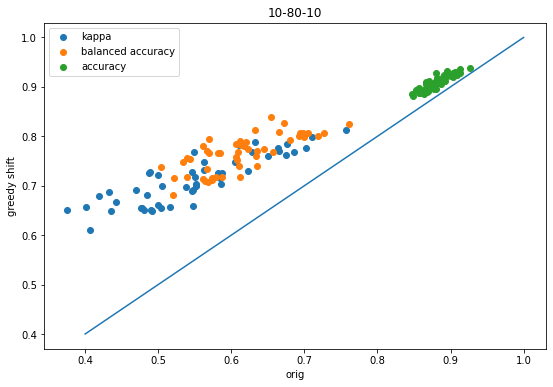

And here's the same plot for 20 different random stratified train/tests splits with target CHEMBL205 (carbonic anhydrase II) with activity thresholds chosen to give a 19-72-9 class split:
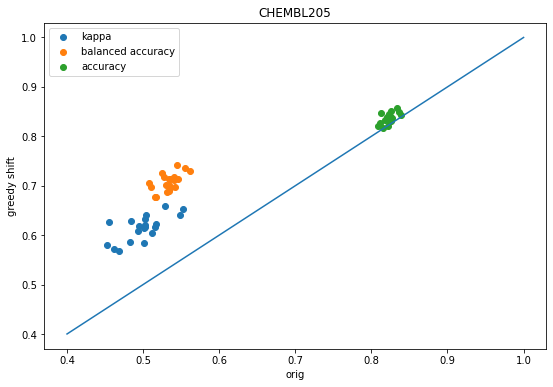


And now onto the code and more detailed exploration

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
import ghostml
import pandas as pd
from sklearn import metrics
import numpy as np


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Code we'll use

In [2]:
def ternary_rebin(probs,thresholds):
    ''' returns a list of classifications based on the provided predicted probabilities and thresholds '''
    res = []
    for prob in probs:
        if prob[0]>=thresholds[0]:
            # we might still be in class 2 if the relative probability of that
            # is larger than the probability of class 0
            if (prob[2]-thresholds[1])>(prob[0]-thresholds[0]):
                res.append(2)
            else:
                res.append(0)
        elif prob[2]>=thresholds[1]:
            res.append(2)
        else:
            res.append(1)
    return res

def run_ternary_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = 'Kappa'):
    ''' does a grid search to optimize the decision thresholds for a ternary problem '''
    res = []
    tscores = []
    for t1 in thresholds:
        for t2 in thresholds:
            preds = ternary_rebin(oob_probs,(t1,t2))
            if ThOpt_metrics == 'Kappa':
                tgt = metrics.cohen_kappa_score(labels_train,preds)
            elif ThOpt_metrics == 'BalancedAccuracy':
                tgt = metrics.balanced_accuracy_score(labels_train,preds)
            elif ThOpt_metrics == 'F1':
                tgt = metrics.f1_score(labels_train,preds)
            tscores.append((np.round(tgt,3),(t1,t2)))
    tscores.sort(reverse=True)
    thresh = tscores[0][-1]
    return thresh


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def run_ternary_experiment(X,y,accum,random_state=0):
    ''' experiment wrapper for the ternary bounds optimization '''
    n_classes = max(y)+1
    local = {}
    
    # --------------------
    # Train - test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, 
                                                        random_state=random_state)

    # --------------------
    # Train a RF classifier
    cls = RandomForestClassifier(n_estimators=500,max_depth=10,oob_score=True,n_jobs=8)
    cls.fit(X_train, y_train)


    # --------------------
    # Calculate the baseline accuracy values
    test_preds = cls.predict(X_test)
    test_probs = cls.predict_proba(X_test)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('original')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['orig-accuracy'] = accuracy
    local['orig-balanced'] = balanced
    local['orig-kappa'] = kappa
    local['orig-confusion'] = confusion
    
    # --------------------
    # optimize the two thresholds individually
    thresholds = [0]*(n_classes-1)
    for i,clsv in enumerate((0,2)):
        d_tform = [1 if y==clsv else 0 for y in y_train]
        d_probs = [x[clsv] for x in cls.oob_decision_function_]
        thresholds[i] = ghostml.optimize_threshold_from_oob_predictions(d_tform,d_probs,thresholds=np.arange(0.05,1.0,0.05))
    local['thresholds'] = thresholds
   
    # calculate the accuracy values for those thresholds:
    test_preds = ternary_rebin(test_probs,thresholds)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('rebalanced')
    print(f'thresholds: {thresholds}')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['shift-accuracy'] = accuracy
    local['shift-balanced'] = balanced
    local['shift-kappa'] = kappa
    local['shift-confusion'] = confusion
    
    
    # --------------------
    # grid-search optimization of the threshold values based on kappa
    thresholds = run_ternary_oob_optimization(cls.oob_decision_function_,y_train,
                                                   thresholds=np.arange(0.05,1.00,0.05),
                                                  ThOpt_metrics = 'Kappa')
    test_preds = ternary_rebin(test_probs,thresholds)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('global kappa rebalanced')
    print(f'thresholds: {thresholds}')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['global-k-shift-accuracy'] = accuracy
    local['global-k-shift-balanced'] = balanced
    local['global-k-shift-kappa'] = kappa
    local['global-k-shift-confusion'] = confusion
    
    # --------------------
    # grid-search optimization of the threshold values based on the balanced accuracy
    thresholds = run_ternary_oob_optimization(cls.oob_decision_function_,y_train,
                                                   thresholds=np.arange(0.05,1.00,0.05),
                                                  ThOpt_metrics = 'BalancedAccuracy')
    test_preds = ternary_rebin(test_probs,thresholds)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('global balanced_accuracy rebalanced')
    print(f'thresholds: {thresholds}')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['global-ba-shift-accuracy'] = accuracy
    local['global-ba-shift-balanced'] = balanced
    local['global-ba-shift-kappa'] = kappa
    local['global-ba-shift-confusion'] = confusion
    
    accum.append(local)

# Synthetic datasets


I will try out a couple of real datasets below, but I want to start by verifying that the process works with some synthetic datasest. Scikit-learn's [make_classification() function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) makes this really easy.


## Try a 10-80-10 split

I will test this with multiple different forms of imbalance, just to be sure that it generalizes. Let's start with an example where the majority class is in the middle:

In [4]:
from sklearn.datasets import make_classification

accum_10_80_10 = []

for rep in range(50):
    print('--------------')
    # Generate a ternary imbalanced classification problem
    X, y = make_classification(n_samples=6000, n_features=20,
                               n_informative=10, n_redundant=0, n_classes=3, 
                               random_state=0xf00d+rep, shuffle=False, weights = [0.1, 0.8, 0.1])
    run_ternary_experiment(X,y,accum_10_80_10)


--------------
original
accuracy: 0.865  balanced accuracy: 0.569  kappa: 0.484
[[ 56  67   1]
 [  1 950   1]
 [  5  87  32]]
rebalanced
thresholds: [0.25, 0.2]
accuracy: 0.892  balanced accuracy: 0.765  kappa: 0.681
[[ 79  41   4]
 [ 14 904  34]
 [  8  28  88]]
global kappa rebalanced
thresholds: (0.25, 0.2)
accuracy: 0.892  balanced accuracy: 0.765  kappa: 0.681
[[ 79  41   4]
 [ 14 904  34]
 [  8  28  88]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.848  balanced accuracy: 0.817  kappa: 0.622
[[ 99  21   4]
 [ 60 820  72]
 [ 10  16  98]]
--------------
original
accuracy: 0.890  balanced accuracy: 0.645  kappa: 0.605
[[ 50  68   5]
 [  1 953   0]
 [  6  52  65]]
rebalanced
thresholds: [0.25, 0.3]
accuracy: 0.920  balanced accuracy: 0.775  kappa: 0.748
[[ 92  28   3]
 [ 11 939   4]
 [ 12  38  73]]
global kappa rebalanced
thresholds: (0.25, 0.2)
accuracy: 0.923  balanced accuracy: 0.800  kappa: 0.766
[[ 85  27  11]
 [ 10 933  1

global balanced_accuracy rebalanced
thresholds: (0.1, 0.15000000000000002)
accuracy: 0.802  balanced accuracy: 0.824  kappa: 0.556
[[109   8   6]
 [145 757  54]
 [ 11  14  96]]
--------------
original
accuracy: 0.877  balanced accuracy: 0.609  kappa: 0.548
[[ 50  69   4]
 [  0 951   3]
 [  5  66  52]]
rebalanced
thresholds: [0.3, 0.25]
accuracy: 0.897  balanced accuracy: 0.768  kappa: 0.690
[[ 73  41   9]
 [ 16 910  28]
 [  4  26  93]]
global kappa rebalanced
thresholds: (0.25, 0.25)
accuracy: 0.895  balanced accuracy: 0.793  kappa: 0.698
[[ 85  31   7]
 [ 29 897  28]
 [  7  24  92]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.823  balanced accuracy: 0.826  kappa: 0.588
[[ 99  14  10]
 [ 80 783  91]
 [  7  11 105]]
--------------
original
accuracy: 0.858  balanced accuracy: 0.539  kappa: 0.436
[[ 34  86   3]
 [  0 954   0]
 [  1  80  42]]
rebalanced
thresholds: [0.25, 0.2]
accuracy: 0.887  balanced accuracy: 0.717  kappa: 0.650

global kappa rebalanced
thresholds: (0.25, 0.2)
accuracy: 0.892  balanced accuracy: 0.732  kappa: 0.666
[[ 87  29   8]
 [ 21 918  15]
 [ 11  46  65]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.853  balanced accuracy: 0.782  kappa: 0.617
[[101  14   9]
 [ 66 843  45]
 [ 12  31  79]]
--------------
original
accuracy: 0.867  balanced accuracy: 0.570  kappa: 0.487
[[ 43  75   4]
 [  1 953   2]
 [  4  74  44]]
rebalanced
thresholds: [0.2, 0.25]
accuracy: 0.907  balanced accuracy: 0.794  kappa: 0.725
[[ 93  21   8]
 [ 12 914  30]
 [ 11  30  81]]
global kappa rebalanced
thresholds: (0.2, 0.25)
accuracy: 0.907  balanced accuracy: 0.794  kappa: 0.725
[[ 93  21   8]
 [ 12 914  30]
 [ 11  30  81]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.867  balanced accuracy: 0.830  kappa: 0.662
[[ 97  14  11]
 [ 26 844  86]
 [ 12  11  99]]
--------------
original
accuracy: 0.887  balanced a

global kappa rebalanced
thresholds: (0.25, 0.2)
accuracy: 0.888  balanced accuracy: 0.755  kappa: 0.667
[[ 84  33   6]
 [ 19 904  31]
 [  7  38  78]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.1)
accuracy: 0.802  balanced accuracy: 0.832  kappa: 0.561
[[106  10   7]
 [ 53 753 148]
 [  7  12 104]]
--------------
original
accuracy: 0.880  balanced accuracy: 0.611  kappa: 0.552
[[ 49  72   2]
 [  1 954   0]
 [  5  64  53]]
rebalanced
thresholds: [0.3, 0.25]
accuracy: 0.906  balanced accuracy: 0.740  kappa: 0.698
[[ 69  43  11]
 [ 12 935   8]
 [  4  35  83]]
global kappa rebalanced
thresholds: (0.25, 0.25)
accuracy: 0.906  balanced accuracy: 0.759  kappa: 0.708
[[ 80  36   7]
 [ 20 927   8]
 [  9  33  80]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.855  balanced accuracy: 0.797  kappa: 0.631
[[ 96  14  13]
 [ 68 841  46]
 [ 15  18  89]]
--------------
original
accuracy: 0.887  balanced accuracy: 0.635 

Start by comparing the model-performance metrics kappa, balanced accuracy, and accuracy between the model with the greedy threshold shift based on kappa and the model with "default thresholds".

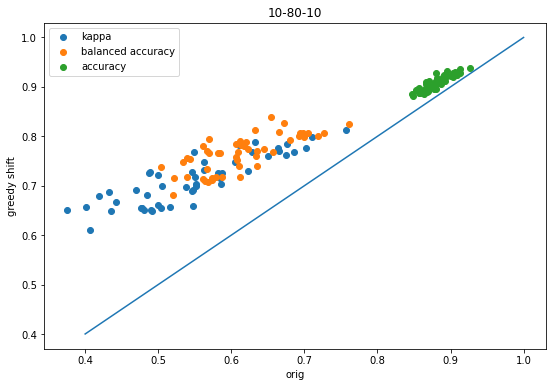

In [5]:
accum = accum_10_80_10
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('10-80-10');

The shift improves all three metrics for every dataset.

Now compare the results for using a grid search based on Cohen's kappa to the greedy shift results:

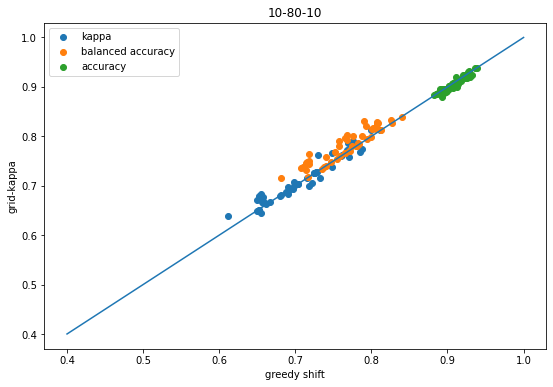

In [6]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('10-80-10');

Here the changes are reasonably small, but they do tend to favor the results of the grid search.

Finally, do the equivalent plot comparing the result from using balanced accuracy in the grid search to the results from the greedy shift:

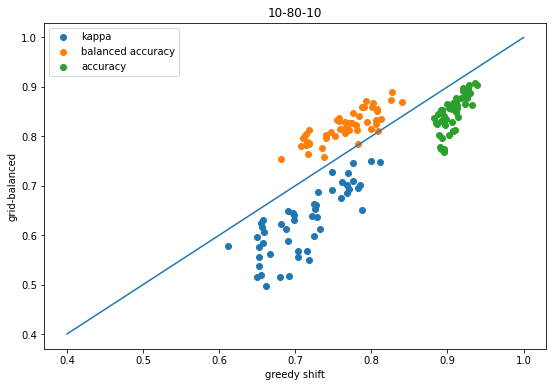

In [7]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('10-80-10');

With these datasets, using balanced accuracy for the optimization results in an improvement in overall balanced accuracy relative to the kappa-driven greedy shift, but both kappa and overall accuracy go down.

This isn't terribly surprising, but perhaps suggests that optimizing the threshold using kappa is a better idea.

## 0 is the majority class

In [8]:
accum_80_10_10 = []

for rep in range(50):
    print('--------------')
    # Generate a ternary imbalanced classification problem
    X, y = make_classification(n_samples=6000, n_features=20,
                               n_informative=10, n_redundant=0, n_classes=3, 
                               random_state=0xf00d+rep, shuffle=False, weights = [0.8, 0.1, 0.1])
    run_ternary_experiment(X,y,accum_80_10_10)


--------------
original
accuracy: 0.887  balanced accuracy: 0.634  kappa: 0.586
[[953   0   1]
 [ 64  55   3]
 [ 64   4  56]]
rebalanced
thresholds: [0.6500000000000001, 0.3]
accuracy: 0.906  balanced accuracy: 0.762  kappa: 0.720
[[925  25   4]
 [ 22  84  16]
 [ 25  21  78]]
global kappa rebalanced
thresholds: (0.6000000000000001, 0.3)
accuracy: 0.912  balanced accuracy: 0.748  kappa: 0.727
[[939  11   4]
 [ 28  78  16]
 [ 28  19  77]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.3)
accuracy: 0.861  balanced accuracy: 0.760  kappa: 0.635
[[864  86   4]
 [ 16  90  16]
 [ 15  30  79]]
--------------
original
accuracy: 0.875  balanced accuracy: 0.596  kappa: 0.527
[[953   1   0]
 [ 71  51   1]
 [ 73   4  46]]
rebalanced
thresholds: [0.7000000000000001, 0.25]
accuracy: 0.907  balanced accuracy: 0.772  kappa: 0.718
[[922  25   7]
 [ 22  90  11]
 [ 37  10  76]]
global kappa rebalanced
thresholds: (0.6500000000000001, 0.25)
accuracy: 0.903  balanced accuracy: 0.742 

global kappa rebalanced
thresholds: (0.6500000000000001, 0.25)
accuracy: 0.927  balanced accuracy: 0.810  kappa: 0.781
[[935  11  10]
 [ 16  90  17]
 [ 23  11  87]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.2)
accuracy: 0.894  balanced accuracy: 0.835  kappa: 0.720
[[880  44  32]
 [  7  89  27]
 [ 12   5 104]]
--------------
original
accuracy: 0.877  balanced accuracy: 0.619  kappa: 0.550
[[946   8   1]
 [ 66  55   1]
 [ 67   5  51]]
rebalanced
thresholds: [0.6500000000000001, 0.25]
accuracy: 0.885  balanced accuracy: 0.745  kappa: 0.655
[[904  39  12]
 [ 40  72  10]
 [ 32   5  86]]
global kappa rebalanced
thresholds: (0.6500000000000001, 0.25)
accuracy: 0.885  balanced accuracy: 0.745  kappa: 0.655
[[904  39  12]
 [ 40  72  10]
 [ 32   5  86]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.2)
accuracy: 0.852  balanced accuracy: 0.774  kappa: 0.616
[[846  72  37]
 [ 24  77  21]
 [ 15   9  99]]
--------------
original
accuracy: 0.853 

global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.2)
accuracy: 0.874  balanced accuracy: 0.829  kappa: 0.680
[[854  48  53]
 [  4  96  22]
 [ 14  10  99]]
--------------
original
accuracy: 0.878  balanced accuracy: 0.603  kappa: 0.553
[[955   0   0]
 [ 62  55   6]
 [ 65  13  44]]
rebalanced
thresholds: [0.7000000000000001, 0.25]
accuracy: 0.900  balanced accuracy: 0.754  kappa: 0.704
[[921  33   1]
 [ 23  73  27]
 [ 25  11  86]]
global kappa rebalanced
thresholds: (0.6000000000000001, 0.3)
accuracy: 0.909  balanced accuracy: 0.730  kappa: 0.707
[[944  10   1]
 [ 38  68  17]
 [ 35   8  79]]
global balanced_accuracy rebalanced
thresholds: (0.8, 0.3)
accuracy: 0.850  balanced accuracy: 0.776  kappa: 0.623
[[843 111   1]
 [  9  97  17]
 [ 12  30  80]]
--------------
original
accuracy: 0.867  balanced accuracy: 0.569  kappa: 0.481
[[953   0   2]
 [ 79  42   2]
 [ 77   0  45]]
rebalanced
thresholds: [0.7000000000000001, 0.2]
accuracy: 0.892  balanced accuracy: 0.777  kap

global kappa rebalanced
thresholds: (0.6500000000000001, 0.25)
accuracy: 0.902  balanced accuracy: 0.773  kappa: 0.710
[[916  33   7]
 [ 19  86  17]
 [ 31  11  80]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.25)
accuracy: 0.873  balanced accuracy: 0.775  kappa: 0.660
[[876  73   7]
 [ 13  92  17]
 [ 18  24  80]]
--------------
original
accuracy: 0.906  balanced accuracy: 0.698  kappa: 0.674
[[952   0   2]
 [ 57  63   3]
 [ 45   6  72]]
rebalanced
thresholds: [0.6500000000000001, 0.3]
accuracy: 0.927  balanced accuracy: 0.802  kappa: 0.780
[[938  12   4]
 [ 21  89  13]
 [ 24  13  86]]
global kappa rebalanced
thresholds: (0.6000000000000001, 0.3)
accuracy: 0.928  balanced accuracy: 0.788  kappa: 0.777
[[945   5   4]
 [ 27  83  13]
 [ 27  10  86]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.3)
accuracy: 0.897  balanced accuracy: 0.801  kappa: 0.714
[[896  54   4]
 [ 16  94  13]
 [ 17  20  86]]
--------------
original
accuracy: 0.864  

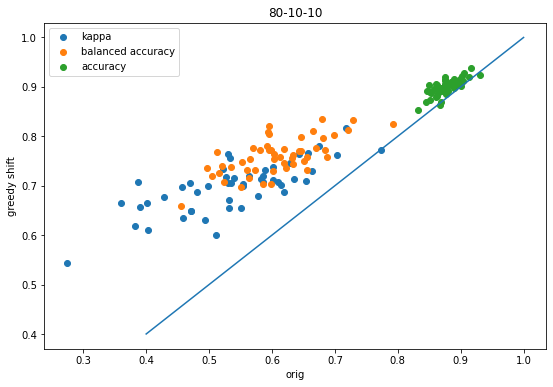

In [9]:
accum = accum_80_10_10
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('80-10-10');

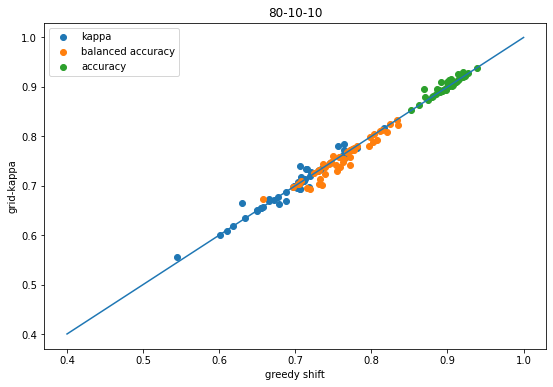

In [10]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('80-10-10');

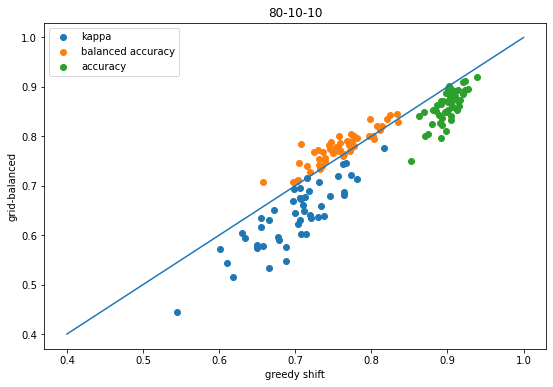

In [11]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('80-10-10');

## 2 is the majority class

In [12]:
accum_10_10_80 = []

for rep in range(50):
    print('--------------')
    # Generate a ternary imbalanced classification problem
    X, y = make_classification(n_samples=6000, n_features=20,
                               n_informative=10, n_redundant=0, n_classes=3, 
                               random_state=0xf00d+rep, shuffle=False, weights = [0.1, 0.1, 0.8])
    run_ternary_experiment(X,y,accum_10_10_80)


--------------
original
accuracy: 0.874  balanced accuracy: 0.594  kappa: 0.521
[[ 52   1  71]
 [  2  44  75]
 [  2   0 953]]
rebalanced
thresholds: [0.3, 0.7000000000000001]
accuracy: 0.895  balanced accuracy: 0.743  kappa: 0.683
[[ 76  21  27]
 [  8  79  34]
 [ 10  26 919]]
global kappa rebalanced
thresholds: (0.3, 0.6500000000000001)
accuracy: 0.899  balanced accuracy: 0.728  kappa: 0.680
[[ 76  12  36]
 [  8  72  41]
 [  9  15 931]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.7500000000000001)
accuracy: 0.876  balanced accuracy: 0.760  kappa: 0.655
[[ 92  14  18]
 [ 20  74  27]
 [ 32  38 885]]
--------------
original
accuracy: 0.855  balanced accuracy: 0.531  kappa: 0.421
[[ 45   2  76]
 [  3  28  92]
 [  1   0 953]]
rebalanced
thresholds: [0.25, 0.7000000000000001]
accuracy: 0.894  balanced accuracy: 0.788  kappa: 0.698
[[ 80   9  34]
 [ 12  95  16]
 [ 13  43 898]]
global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.905  balanced accuracy: 0.769 

global kappa rebalanced
thresholds: (0.3, 0.6500000000000001)
accuracy: 0.893  balanced accuracy: 0.750  kappa: 0.682
[[ 71  14  38]
 [ 12  88  23]
 [ 14  27 913]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.7500000000000001)
accuracy: 0.872  balanced accuracy: 0.812  kappa: 0.667
[[ 95   8  20]
 [ 19  94  10]
 [ 31  66 857]]
--------------
original
accuracy: 0.880  balanced accuracy: 0.608  kappa: 0.554
[[ 51   4  68]
 [  7  50  65]
 [  0   0 955]]
rebalanced
thresholds: [0.25, 0.6500000000000001]
accuracy: 0.900  balanced accuracy: 0.728  kappa: 0.684
[[ 84   8  31]
 [ 15  64  43]
 [  4  19 932]]
global kappa rebalanced
thresholds: (0.25, 0.6000000000000001)
accuracy: 0.901  balanced accuracy: 0.714  kappa: 0.678
[[ 82   7  34]
 [ 15  60  47]
 [  3  13 939]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.7500000000000001)
accuracy: 0.863  balanced accuracy: 0.755  kappa: 0.628
[[ 96   6  21]
 [ 25  70  27]
 [ 19  66 870]]
--------------
original
accuracy: 0.859  

original
accuracy: 0.838  balanced accuracy: 0.478  kappa: 0.324
[[ 41   0  83]
 [  3  13 107]
 [  1   0 952]]
rebalanced
thresholds: [0.25, 0.7000000000000001]
accuracy: 0.881  balanced accuracy: 0.706  kappa: 0.626
[[ 76  10  38]
 [  4  67  52]
 [ 12  27 914]]
global kappa rebalanced
thresholds: (0.2, 0.7000000000000001)
accuracy: 0.880  balanced accuracy: 0.707  kappa: 0.626
[[ 83   5  36]
 [ 10  61  52]
 [ 20  21 912]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.8)
accuracy: 0.800  balanced accuracy: 0.738  kappa: 0.519
[[ 86  20  18]
 [ 10  85  28]
 [ 25 139 789]]
--------------
original
accuracy: 0.887  balanced accuracy: 0.637  kappa: 0.585
[[ 52   1  70]
 [  1  60  62]
 [  1   0 953]]
rebalanced
thresholds: [0.25, 0.6500000000000001]
accuracy: 0.910  balanced accuracy: 0.785  kappa: 0.734
[[ 91  10  22]
 [ 16  80  27]
 [ 14  19 921]]
global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.910  balanced accuracy: 0.785  kappa: 0.734
[[ 91  10  22]


global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.919  balanced accuracy: 0.811  kappa: 0.757
[[104   5  13]
 [  8  75  39]
 [ 16  16 924]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.7500000000000001)
accuracy: 0.889  balanced accuracy: 0.842  kappa: 0.707
[[107   7   8]
 [ 13  90  19]
 [ 31  55 870]]
--------------
original
accuracy: 0.861  balanced accuracy: 0.547  kappa: 0.450
[[ 54   0  69]
 [  4  25  94]
 [  0   0 954]]
rebalanced
thresholds: [0.25, 0.7000000000000001]
accuracy: 0.897  balanced accuracy: 0.766  kappa: 0.696
[[101   9  13]
 [ 13  64  46]
 [ 15  27 912]]
global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.903  balanced accuracy: 0.742  kappa: 0.697
[[101   7  15]
 [ 13  53  57]
 [ 15   9 930]]
global balanced_accuracy rebalanced
thresholds: (0.25, 0.8)
accuracy: 0.813  balanced accuracy: 0.785  kappa: 0.562
[[101  16   6]
 [ 13  87  23]
 [ 15 151 788]]
--------------
original
accuracy: 0.854  balanced accu

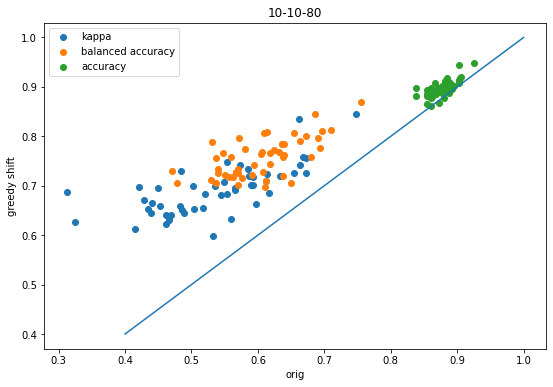

In [13]:
accum = accum_10_10_80
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('10-10-80');

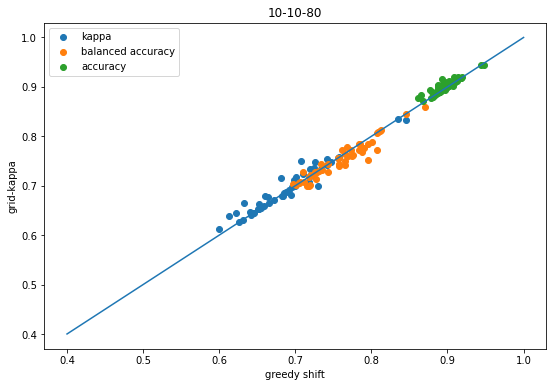

In [14]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('10-10-80');

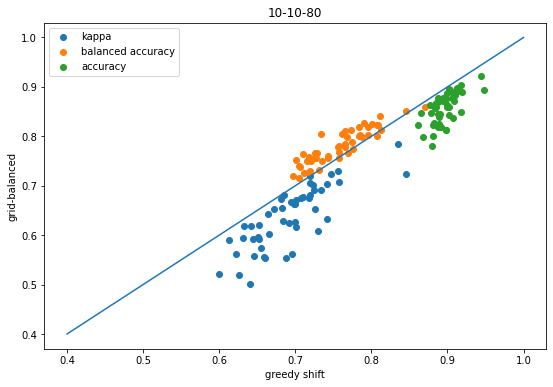

In [15]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('10-10-80');

# Some ChEMBL datasets

## CHEMBL205: Carbonic Anhydrase II

,compound_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation,standard_type,year,ROMol,pKi
0,CHEMBL1054,NS(=O)(=O)c1cc2c(cc1Cl)NC(C(Cl)Cl)NS2(=O)=O,91.0,nM,=,Ki,2009,,7.040959
1,CHEMBL1055,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,138.0,nM,=,Ki,2009,,6.860121
2,CHEMBL1060,O=P([O-])([O-])O.[Na+].[Na+],13200000.0,nM,=,Ki,2004,,1.879426
3,CHEMBL106848,NS(=O)(=O)c1ccc(SCCO)cc1,21.0,nM,=,Ki,2013,,7.677781
4,CHEMBL107217,CCN(CC)C(=S)[S-].[Na+],3100.0,nM,=,Ki,2009,,5.508638

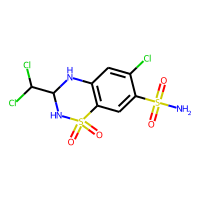
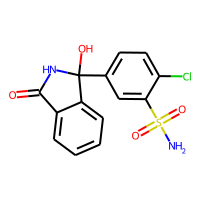
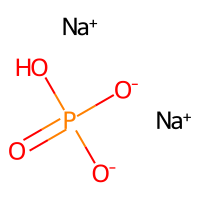
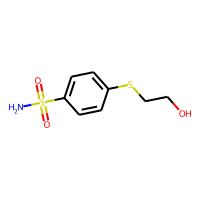
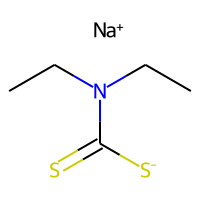

In [16]:
data = pd.read_csv('../data/target_CHEMBL205.csv.gz')
PandasTools.AddMoleculeColumnToFrame(data,smilesCol='canonical_smiles')
data['pKi'] = [-math.log10(x*1e-9) for x in data['standard_value']]
data.head()

Pick two pKi values for binning

In [17]:
def binner(act,bins=(5,8.5)):
    for i,bin in enumerate(bins):
        if act<=bin:
            return i
    return len(bins)
data['activity'] = [binner(x) for x in data.pKi]
data.groupby('activity').describe()

standard_value                                                     \
                  count          mean           std        min         25%   
activity                                                                     
0                 968.0  1.242009e+18  3.864224e+19  10000.000  10000.0000   
1                3582.0  7.292523e+02  1.778519e+03      3.200     13.5000   
2                 427.0  1.309327e+00  8.709364e-01      0.008      0.6355   

                                               year               ...          \
              50%         75%           max   count         mean  ...     75%   
activity                                                          ...           
0         50000.0  196700.000  1.202264e+21   968.0  2012.994835  ...  2016.0   
1            73.4     417.750  9.900000e+03  3582.0  2013.261307  ...  2017.0   
2             1.0       2.035  3.100000e+00   427.0  2014.962529  ...  2017.0   

                     pKi                                                     \
             max   count      mean       std        min       25%       50%   
activity                                                                      
0         2020.0   968.0  4.069107  1.200449 -12.080000  3.706216  4.301030   
1         2020.0  3582.0  7.050231  0.915651   5.004365  6.379084  7.134306   
2         2020.0   427.0  9.050659  0.500779   8.508638  8.691437  9.000000   

                              
               75%       max  
activity                      
0         5.000000   5.00000  
1         7.869666   8.49485  
2         9.196895  11.09691  

[3 rows x 24 columns]

Ok, that's imbalanced :-)

Generate fingerprints:

In [18]:
from rdkit.Chem import SaltRemover
sr = SaltRemover.SaltRemover()
stripped = [sr.StripMol(m) for m in data.ROMol]
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
fps = [fpgen.GetFingerprint(m) for m in stripped]

And now run the experiment with 20 random splits:

In [19]:
accum_chembl205 = []
for i in range(20):
    run_ternary_experiment(fps,data.activity,accum_chembl205,random_state=0xf00d+i)


original
accuracy: 0.838  balanced accuracy: 0.555  kappa: 0.549
[[133  61   0]
 [ 15 702   0]
 [  0  85   0]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.843  balanced accuracy: 0.735  kappa: 0.641
[[159  34   1]
 [ 46 639  32]
 [  0  43  42]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.843  balanced accuracy: 0.735  kappa: 0.641
[[159  34   1]
 [ 46 639  32]
 [  0  43  42]]
global balanced_accuracy rebalanced
thresholds: (0.3, 0.1)
accuracy: 0.715  balanced accuracy: 0.777  kappa: 0.497
[[179  10   5]
 [ 92 469 156]
 [  2  19  64]]
original
accuracy: 0.821  balanced accuracy: 0.540  kappa: 0.501
[[122  72   0]
 [ 22 694   1]
 [  1  82   2]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.833  balanced accuracy: 0.718  kappa: 0.615
[[152  42   0]
 [ 45 637  35]
 [  1  43  41]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.833  balanced accuracy: 0.718  kappa: 0.615
[[152  42   0]
 [ 45 637  35]

original
accuracy: 0.826  balanced accuracy: 0.541  kappa: 0.516
[[126  68   0]
 [ 20 697   0]
 [  3  82   0]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.837  balanced accuracy: 0.711  kappa: 0.617
[[148  45   1]
 [ 47 646  24]
 [  1  44  40]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.837  balanced accuracy: 0.711  kappa: 0.617
[[148  45   1]
 [ 47 646  24]
 [  1  44  40]]
global balanced_accuracy rebalanced
thresholds: (0.3, 0.1)
accuracy: 0.764  balanced accuracy: 0.781  kappa: 0.548
[[173  21   0]
 [ 98 527  92]
 [  2  22  61]]
original
accuracy: 0.822  balanced accuracy: 0.535  kappa: 0.502
[[123  71   0]
 [ 21 696   0]
 [  2  83   0]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.833  balanced accuracy: 0.713  kappa: 0.616
[[156  37   1]
 [ 51 636  30]
 [  2  45  38]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.833  balanced accuracy: 0.713  kappa: 0.616
[[156  37   1]
 [ 51 636  30]

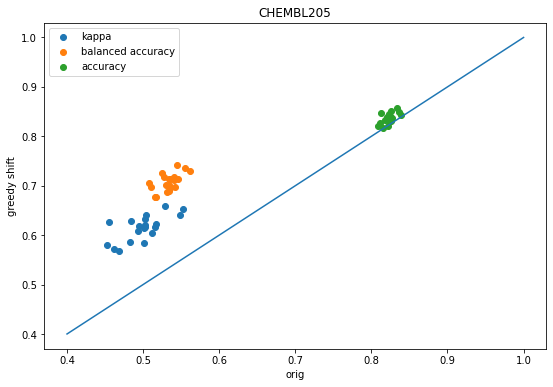

In [20]:
accum = accum_chembl205
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('CHEMBL205');

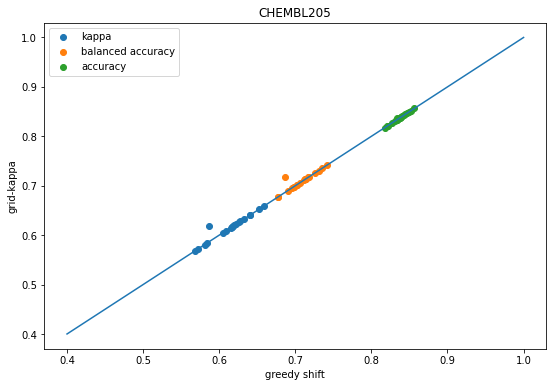

In [21]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('CHEMBL205');

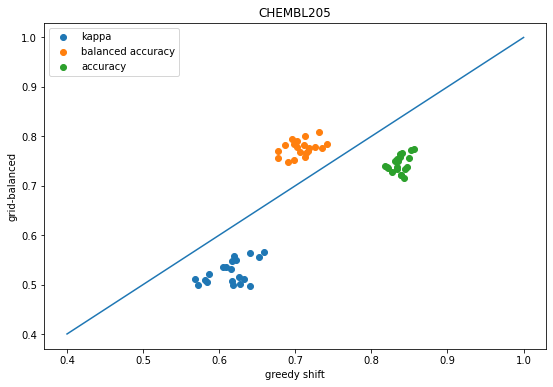

In [22]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('CHEMBL205');

## CHEMBL217: Dopamine D2

In [23]:
data = pd.read_csv('../data/target_CHEMBL217.csv.gz')
PandasTools.AddMoleculeColumnToFrame(data,smilesCol='canonical_smiles')
data['pKi'] = [-math.log10(x*1e-9) for x in data['standard_value']]
def binner(act,bins=(5,8)):
    for i,bin in enumerate(bins):
        if act<=bin:
            return i
    return len(bins)
data['activity'] = [binner(x) for x in data.pKi]
data.groupby('activity').describe()

standard_value                                                       \
                  count           mean            std        min         25%   
activity                                                                       
0                 356.0  143415.189354  781194.668326  10000.000  10000.0000   
1                4014.0     830.546163    1471.610125     10.000     63.1875   
2                 607.0       3.715942       2.786155      0.027      1.2150   

                                            year               ...          \
               50%      75%          max   count         mean  ...     75%   
activity                                                       ...           
0         10000.00  24234.5  10000000.00   356.0  2011.679775  ...  2017.0   
1           238.51    931.0      9906.00  4014.0  2011.100648  ...  2015.0   
2             3.00      5.9         9.86   607.0  2011.957166  ...  2016.0   

                     pKi                                                    \
             max   count      mean       std       min       25%       50%   
activity                                                                     
0         2019.0   356.0  4.672916  0.581865  2.000000  4.615626  5.000000   
1         2020.0  4014.0  6.620074  0.724919  5.004102  6.031050  6.622494   
2         2019.0   607.0  8.614671  0.475862  8.006123  8.229148  8.522879   

                               
               75%        max  
activity                       
0         5.000000   5.000000  
1         7.199370   8.000000  
2         8.915457  10.568636  

[3 rows x 24 columns]

In [24]:
from rdkit.Chem import SaltRemover
sr = SaltRemover.SaltRemover()
stripped = [sr.StripMol(m) for m in data.ROMol]
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
fps = [fpgen.GetFingerprint(m) for m in stripped]

In [25]:
accum_chembl217 = []
for i in range(20):
    run_ternary_experiment(fps,data.activity,accum_chembl217,random_state=0xf00d+i)


original
accuracy: 0.831  balanced accuracy: 0.431  kappa: 0.232
[[  8  63   0]
 [  0 797   6]
 [  0  99  23]]
rebalanced
thresholds: [0.1, 0.2]
accuracy: 0.834  balanced accuracy: 0.643  kappa: 0.475
[[ 34  37   0]
 [ 28 731  44]
 [  1  55  66]]
global kappa rebalanced
thresholds: (0.15000000000000002, 0.2)
accuracy: 0.836  balanced accuracy: 0.571  kappa: 0.433
[[ 17  54   0]
 [  9 750  44]
 [  0  56  66]]
global balanced_accuracy rebalanced
thresholds: (0.1, 0.1)
accuracy: 0.721  balanced accuracy: 0.675  kappa: 0.372
[[ 34  30   7]
 [ 26 584 193]
 [  1  21 100]]
original
accuracy: 0.834  balanced accuracy: 0.429  kappa: 0.243
[[  5  66   0]
 [  2 799   2]
 [  0  95  27]]
rebalanced
thresholds: [0.1, 0.2]
accuracy: 0.839  balanced accuracy: 0.676  kappa: 0.505
[[ 39  32   0]
 [ 33 727  43]
 [  0  52  70]]
global kappa rebalanced
thresholds: (0.15000000000000002, 0.2)
accuracy: 0.844  balanced accuracy: 0.605  kappa: 0.474
[[ 22  49   0]
 [ 11 749  43]
 [  0  52  70]]
global balanced

global kappa rebalanced
thresholds: (0.1, 0.2)
accuracy: 0.840  balanced accuracy: 0.708  kappa: 0.529
[[ 43  28   0]
 [ 36 718  49]
 [  1  45  76]]
global balanced_accuracy rebalanced
thresholds: (0.1, 0.1)
accuracy: 0.737  balanced accuracy: 0.728  kappa: 0.417
[[ 42  24   5]
 [ 36 587 180]
 [  1  16 105]]
original
accuracy: 0.834  balanced accuracy: 0.437  kappa: 0.253
[[  7  64   0]
 [  2 797   4]
 [  0  95  27]]
rebalanced
thresholds: [0.15000000000000002, 0.15000000000000002]
accuracy: 0.840  balanced accuracy: 0.647  kappa: 0.504
[[ 24  47   0]
 [ 12 728  63]
 [  0  37  85]]
global kappa rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.840  balanced accuracy: 0.647  kappa: 0.504
[[ 24  47   0]
 [ 12 728  63]
 [  0  37  85]]
global balanced_accuracy rebalanced
thresholds: (0.1, 0.1)
accuracy: 0.734  balanced accuracy: 0.713  kappa: 0.402
[[ 41  27   3]
 [ 36 589 178]
 [  1  20 101]]
original
accuracy: 0.843  balanced accuracy: 0.473  kappa: 0.306
[[ 1

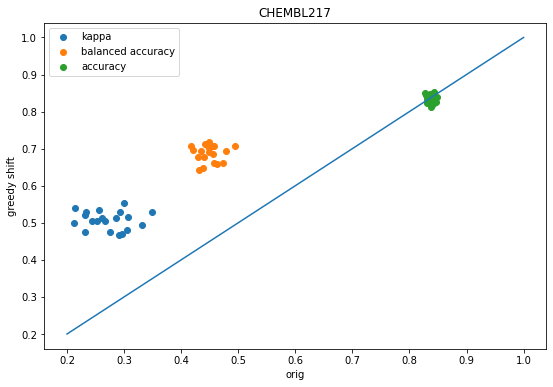

In [26]:
accum = accum_chembl217
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.2,1],[.2,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('CHEMBL217');

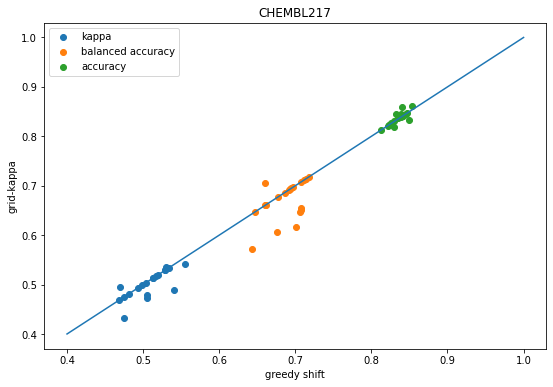

In [27]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('CHEMBL217');

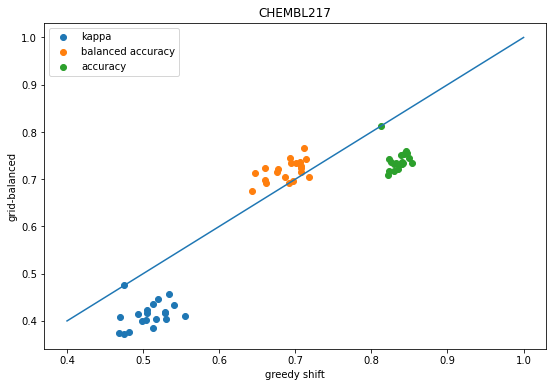

In [28]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('CHEMBL217');